In [1]:
import psycopg2
import configparser
import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
import pandas as pd
from datetime import *
from matplotlib.pyplot import *

In [2]:
def create_connection():
    conn = psycopg2.connect("host=127.0.0.1 dbname=dmqldb user=postgres password=student")
    cur = conn.cursor()       
    return conn, cur

conn, cur = create_connection()

In [3]:
cur.execute("""select open, date, symbol 
                    from stock_history 
                    where symbol = 'AAPL' 
                    order by date desc
                    limit 59""")
result = cur.fetchall()
df = pd.DataFrame(result, columns = ['Open', 'Date', 'Symbol'])

msft = yf.Ticker('AAPL')
list_msft = msft.info
curr_price = list_msft.get('currentPrice')
today = date.today()
latest_info = [curr_price, today, 'AAPL']

In [30]:
latest_info[1]+timedelta(days=1)

datetime.date(2021, 12, 5)

In [4]:
df.tail()

,Open,Date,Symbol
54,148.603125,2021-09-17,AAPL
55,148.223670,2021-09-16,AAPL
56,148.343489,2021-09-15,AAPL
57,150.130890,2021-09-14,AAPL
58,150.410490,2021-09-13,AAPL


In [5]:
dict_ = dict(zip(['Open', 'Date', 'Symbol'], latest_info))
dict_ = {_: [dict_[_]] for _ in dict_}

In [6]:
dict_

{'Open': [161.84], 'Date': [datetime.date(2021, 12, 4)], 'Symbol': ['AAPL']}

In [7]:
df_del = pd.DataFrame(dict_)

In [8]:
df = pd.concat([df, df_del], ignore_index=True, sort=True, axis=0)

In [9]:
df.sort_values(by='Date', ascending=True, inplace=True)
df.index = range(len(df))

In [10]:
df.tail()

,Date,Open,Symbol
55,2021-11-30,159.990005,AAPL
56,2021-12-01,167.479996,AAPL
57,2021-12-02,158.740005,AAPL
58,2021-12-03,164.020004,AAPL
59,2021-12-04,161.840000,AAPL


In [11]:
# Finding missing values
t1 = df.Date[0]
t2 = df.Date.iloc[-1]
df_all = pd.DataFrame({'Date': [(t1+timedelta(days=_)) for _ in range((t2-t1).days+1)]})

df = df_all.merge(df, on='Date', how='left')
df = df.ffill()

In [12]:
df.head()

,Date,Open,Symbol
0,2021-09-13,150.410490,AAPL
1,2021-09-14,150.130890,AAPL
2,2021-09-15,148.343489,AAPL
3,2021-09-16,148.223670,AAPL
4,2021-09-17,148.603125,AAPL


In [13]:
df = df.tail(60)
df.index = range(len(df))

In [14]:
df.drop(columns='Symbol', axis=1, inplace=True)
df_hist = df

In [15]:
# Creating Lagged Features
df = pd.concat([df.Open]+[df.Open.shift(-_) for _ in range(1, 60)], axis=1)
df.columns = ['Open_{}'.format(_) for _ in range(len(df.columns))]
df = df.dropna(axis=0)

In [16]:
df

,Open_0,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,Open_8,Open_9,...,Open_50,Open_51,Open_52,Open_53,Open_54,Open_55,Open_56,Open_57,Open_58,Open_59
0,139.266749,142.851516,143.8201,143.8201,143.8201,142.062677,143.021267,141.034172,141.902902,143.560489,...,160.75,159.570007,159.570007,159.570007,159.369995,159.990005,167.479996,158.740005,164.020004,161.84


In [17]:
cur.execute("select * from means where symbol = 'AAPL'")
result = cur.fetchall()
df_mean = pd.DataFrame(result)

cur.execute("select * from standard_deviation where symbol = 'AAPL'")
result = cur.fetchall()
df_std = pd.DataFrame(result)

val_lst = df_mean.values.tolist()[0]
target_mean = val_lst[-1]

mean_list = []
for i in range(1, len(val_lst)-1):
    mean_list.append(val_lst[i])
    
val_lst = df_std.values.tolist()[0]
target_std = val_lst[-1]

std_list = []
for i in range(1, len(val_lst)-1):
    std_list.append(val_lst[i])

In [18]:
# Scale Data
for _ , col_ in enumerate(df.columns):
    df[col_+'scaled'] = df[col_].apply(lambda x: (x - mean_list[_])/std_list[_])

In [19]:
df

,Open_0,Open_1,Open_2,Open_3,Open_4,Open_5,Open_6,Open_7,Open_8,Open_9,...,Open_50scaled,Open_51scaled,Open_52scaled,Open_53scaled,Open_54scaled,Open_55scaled,Open_56scaled,Open_57scaled,Open_58scaled,Open_59scaled
0,139.266749,142.851516,143.8201,143.8201,143.8201,142.062677,143.021267,141.034172,141.902902,143.560489,...,4.623098,4.578476,4.572855,4.567156,4.554856,4.569707,4.810507,4.517689,4.685531,4.608374


In [20]:
# Prepare X-y data
df = df[[_ for _ in df.columns if 'scaled' in _]]

df = df.to_numpy()

In [21]:
df

array([[4.16955809, 4.28995158, 4.31871228, 4.31362052, 4.30836503,
        4.2416436 , 4.26970601, 4.19527797, 4.22012696, 4.27227294,
        4.26662192, 4.26117678, 4.24436584, 4.36117252, 4.41342961,
        4.41126779, 4.4355515 , 4.43002518, 4.4245423 , 4.3843467 ,
        4.4009423 , 4.396205  , 4.40614694, 4.31186817, 4.306192  ,
        4.30046448, 4.35518699, 4.33861706, 4.39187334, 4.42675503,
        4.43932367, 4.43375962, 4.42826157, 4.40647073, 4.36016721,
        4.34866917, 4.30762238, 4.28446793, 4.27916026, 4.27385164,
        4.33351987, 4.31382209, 4.34370363, 4.42856227, 4.5542171 ,
        4.54850843, 4.54267463, 4.67071563, 4.64664703, 4.62872653,
        4.62309836, 4.57847596, 4.57285495, 4.56715642, 4.55485641,
        4.5697071 , 4.8105073 , 4.51768914, 4.68553133, 4.60837427]])

In [22]:
# Converting to 3-D tensor
df = df.reshape(df.shape[0], df.shape[1] , 1)

In [23]:
# Loading Saved Model
import tensorflow
model = tensorflow.keras.models.load_model('LSTM_APPLE.h5')

In [24]:
# Predictions
predictions = model.predict(df)
predictions = [predictions[_][0] for _ in range(len(predictions))]
y_test_predicted = [(_*target_std)+target_mean for _ in predictions]

In [37]:
y_test_predicted

[160.28157937641694]

In [27]:
df_latest = df_hist.tail(7)

In [31]:
df_latest.columns

Index(['Date', 'Open'], dtype='object')

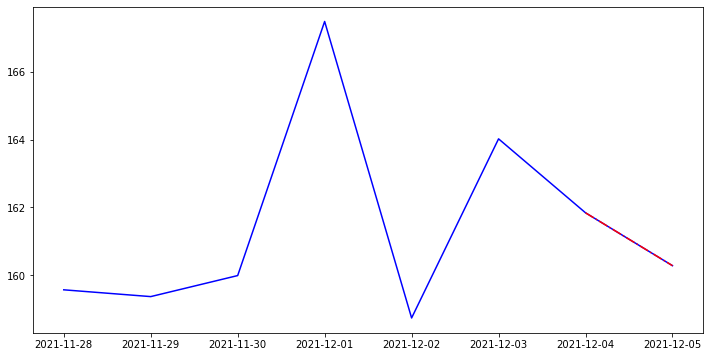

In [47]:
figure(figsize=(12, 6))
plot(list(df_latest.Date.astype('str').values)+[(latest_info[1]+timedelta(days=1)).__str__()], list(df_latest.Open.values)+y_test_predicted, color='blue')
plot(list(df_latest.Date.astype('str').tail(1).values)+[(latest_info[1]+timedelta(days=1)).__str__()], list(df_latest.Open.tail(1).values)+y_test_predicted, '-.', color='red')


In [35]:
list(df_latest.Date.astype('str').values)+[(latest_info[1]+timedelta(days=1)).__str__()]

['2021-11-28',
 '2021-11-29',
 '2021-11-30',
 '2021-12-01',
 '2021-12-02',
 '2021-12-03',
 '2021-12-04',
 '2021-12-05']

In [34]:
list(df_latest.Open.values)+[y_test_predicted]

[159.57000732421875,
 159.3699951171875,
 159.99000549316406,
 167.47999572753906,
 158.74000549316406,
 164.02000427246094,
 161.84,
 [160.28157937641694]]